# Result Analysis of the Car Network

In [203]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

def validFiles(files):
    validFiles = []
    for file in files:
        if os.path.exists(file):
            validFiles.append(file)
    return validFiles

## Read Sim Results

In [204]:
simFolder = "."

sufE2E = "_E2EDelay.json"
sufPubCreated = "_PubCreated.json"
sufSubCreated = "_SubCreated.json"
sufPubRemotes = "_PubRemotes.json"
sufSubRemotes = "_SubRemotes.json"
sufSwitchIdleSlopes = "_SwitchIdleSlopes.json"
sufSwitchQueueDelay = "_SwitchQueueDelay.json"
sufSwitchQueueLength = "_SwitchQueueLength.json"

scenarios = [
    "CMI_B250",
    "CMI_B500",
    "CMI_B1000",
    "SI",
    "Dyrectsn",
    "SI_NoSDScatter"
]

def getScenarioFromFileName(fileName):
    if "NoSDScatter" in fileName:
        return "SI_NoSDScatter"
    for scenario in scenarios:
        if scenario in fileName:
            return scenario
    return None

### Bandwidth Reservation

In [205]:
isFiles = []
for scenario in scenarios:
    isFiles.append(simFolder + "/" + scenario + sufSwitchIdleSlopes)
isFiles = validFiles(isFiles)
print(isFiles)

['./CMI_B250_SwitchIdleSlopes.json', './CMI_B500_SwitchIdleSlopes.json', './CMI_B1000_SwitchIdleSlopes.json', './SI_SwitchIdleSlopes.json', './Dyrectsn_SwitchIdleSlopes.json', './SI_NoSDScatter_SwitchIdleSlopes.json']


In [206]:
def getNodeFromModule (module):
    return module.split(".")[1]

def getPortFromModule (module):
    return int(module.split(".")[2].split("[")[1].split("]")[0])

def getPCPFromModule (module):
    return int(module.split(".")[-1].split("[")[1].split("]")[0])

def isModuleWithPcp(module, pcp):
    return getPCPFromModule(module) == pcp

def getAllIdleSlopesForSimStudy(simFile):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                module = vector["module"]
                node = getNodeFromModule(module)
                port = getPortFromModule(module)
                pcp = getPCPFromModule(module)
                if node not in results:
                    results[node] = dict()
                if port not in results[node]:
                    results[node][port] = dict()
                results[node][port][pcp] = vector["value"][-1] # last value
    return results

def addSumToIdleSlopeVector(idleSlopes):
    for node in idleSlopes:
        for port in idleSlopes[node]:
            sum = 0
            for pcp in idleSlopes[node][port]:
                sum += idleSlopes[node][port][pcp]
            idleSlopes[node][port]["Total"] = sum
    return idleSlopes

def getMinIdleSlope(idleSlopes, pcp, ignoreZero = False):
    min = 1000000000
    for node in idleSlopes:
        for port in idleSlopes[node]:
            if idleSlopes[node][port][pcp] < min:
                if ignoreZero and idleSlopes[node][port][pcp] == 0:
                    continue
                min = idleSlopes[node][port][pcp]
    return min

def getMaxIdleSlope(idleSlopes, pcp):
    max = 0
    for node in idleSlopes:
        for port in idleSlopes[node]:
            if idleSlopes[node][port][pcp] > max:
                max = idleSlopes[node][port][pcp]
    return max

def getAvgIdleSlope(idleSlopes, pcp):
    sum = 0
    count = 0
    for node in idleSlopes:
        for port in idleSlopes[node]:
            if pcp == "Total":
                sum += (idleSlopes[node][port][4]/1000000 + idleSlopes[node][port][5]/1000000) / 2
            else:
                sum += idleSlopes[node][port][pcp]/1000000
            count += 1
    return (sum / count) * 1000000

In [207]:
idleSlopes = dict()
for file in isFiles:
    scenario = getScenarioFromFileName(file)
    idleSlopes[scenario] = getAllIdleSlopesForSimStudy(file)
    idleSlopes[scenario] = addSumToIdleSlopeVector(idleSlopes[scenario])
print(idleSlopes)

{'CMI_B250': {'switchFrontLeft': {0: {4: 170240000, 5: 128640000, 'Total': 298880000}, 1: {4: 0, 5: 0, 'Total': 0}, 2: {4: 0, 5: 0, 'Total': 0}, 3: {4: 398240000, 5: 0, 'Total': 398240000}, 4: {4: 118560000, 5: 0, 'Total': 118560000}}, 'switchFrontRight': {0: {4: 188480000, 5: 314112000, 'Total': 502592000}, 1: {4: 0, 5: 0, 'Total': 0}, 2: {4: 0, 5: 0, 'Total': 0}, 3: {4: 364800000, 5: 0, 'Total': 364800000}}, 'switchRearLeft': {0: {4: 21280000, 5: 314112000, 'Total': 335392000}, 1: {4: 0, 5: 0, 'Total': 0}, 2: {4: 0, 5: 0, 'Total': 0}, 3: {4: 139840000, 5: 0, 'Total': 139840000}}, 'switchRearRight': {0: {4: 240160000, 5: 0, 'Total': 240160000}, 1: {4: 0, 5: 885504000, 'Total': 885504000}, 2: {4: 319200000, 5: 0, 'Total': 319200000}, 3: {4: 0, 5: 0, 'Total': 0}}, 'switchCenter': {0: {4: 389120000, 5: 0, 'Total': 389120000}, 1: {4: 364800000, 5: 0, 'Total': 364800000}, 2: {4: 319200000, 5: 756864000, 'Total': 1076064000}, 3: {4: 139840000, 5: 0, 'Total': 139840000}}}, 'CMI_B500': {'swit

In [208]:
# print idle slopes larger than 800000000
for scenario in idleSlopes:
    print(scenario)
    for node in idleSlopes[scenario]:
        for port in idleSlopes[scenario][node]:
            for pcp in idleSlopes[scenario][node][port]:
                value = idleSlopes[scenario][node][port][pcp]/1000000
                if value > 1000:
                    # print in red
                    print("\033[91m", node, port, pcp, value, "\033[0m")
                elif value > 800:
                    print(node, port, pcp, value, " with ", 1000 - value, "left to 1Gbps")

CMI_B250
switchRearRight 1 5 885.504  with  114.49599999999998 left to 1Gbps
switchRearRight 1 Total 885.504  with  114.49599999999998 left to 1Gbps
 switchCenter 2 Total 1076.064 
CMI_B500
switchRearRight 1 5 885.504  with  114.49599999999998 left to 1Gbps
switchRearRight 1 Total 885.504  with  114.49599999999998 left to 1Gbps
switchCenter 2 Total 916.464  with  83.53599999999994 left to 1Gbps
CMI_B1000
switchRearRight 1 5 885.504  with  114.49599999999998 left to 1Gbps
switchRearRight 1 Total 885.504  with  114.49599999999998 left to 1Gbps
switchCenter 2 Total 836.664  with  163.336 left to 1Gbps
SI
Dyrectsn
switchRearRight 1 5 821.764367  with  178.235633 left to 1Gbps
switchRearRight 1 Total 821.764367  with  178.235633 left to 1Gbps
switchCenter 2 5 882.759437  with  117.24056299999995 left to 1Gbps
switchCenter 2 Total 952.873398  with  47.12660200000005 left to 1Gbps
SI_NoSDScatter


In [209]:
outfile = "tab_car_idleslopes.tex"
with open(outfile, "w") as f:
    f.write("%!TEX root = ../main.tex\n")
    f.write("\\begin{tabularx}{\linewidth}{l l Y Y Y}\n")
    f.write("\\toprule\n")
    f.write("Reservation Scheme & PCP & \\multicolumn{3}{c}{Idle Slope [\si{\mega\\bit\per\second}]} \\\\\n")
    f.write(" & & Min & Avg & Max \\\\\n")
    f.write("\\midrule\n")
    pcps = [4,5,"Total"]
    for scenario in idleSlopes:
        for pcp in pcps:
            min = getMinIdleSlope(idleSlopes[scenario], pcp, True) / 1000000
            max = getMaxIdleSlope(idleSlopes[scenario], pcp) / 1000000
            avg = getAvgIdleSlope(idleSlopes[scenario], pcp) / 1000000
            # print as a latex booktabs table
            scenarioPrint = scenario.replace("_", " ").replace("CMI", "\codeword{Fixed CMI}").replace("SI", "\codeword{Flow interval}").replace("Dyrectsn", "\codeword{Delay Budget}")
            if "B" in scenario:
                scenarioPrint = scenarioPrint.replace("B", "").replace("250", "\SI{250}{\micro\second}").replace("500", "\SI{500}{\micro\second}").replace("1000", "\SI{1}{\milli\second}")
            f.write(scenarioPrint + " & " + str(pcp) + " & $" + format(min,".1f") + "$ & $" + format(avg,".1f") + "$ & $" + format(max,".1f") + "$ \\\\\n")
    f.write("\\bottomrule\n")
    f.write("\\end{tabularx}\n")

### Switch Bandwidth over Time

In [210]:
print(idleSlopes[scenario]["switchRearRight"][1])

{4: 0, 5: 785476924, 'Total': 785476924}


In [211]:
switchPortsOfInterest = {
    "switchRearRight": 1, #'0A-AA-00-00-00-16',
    "switchCenter": 2, #'0A-AA-00-00-00-1B',
}

def createPairVector(vector1, vector2):
    if len(vector1) != len(vector2):
        print("Error: vectors have different lengths")
        return None
    pairVector = []
    for i in range(len(vector1)):
        pairVector.append((vector1[i], vector2[i]))
    return pairVector

def removeLeadingZerosFromPairVector(pairVector):
    for i in range(len(pairVector)):
        if pairVector[i][1] != 0:
            return pairVector[i:]
    return None

def splitPairVector(pairVector):
    x = []
    y = []
    if pairVector == None:
        return x, y
    for pair in pairVector:
        x.append(pair[0])
        y.append(pair[1])
    return x, y

def getIdleSlopeVectorFor(simFile, switch, port):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                module = vector["module"]
                node = getNodeFromModule(module)
                nodePort = getPortFromModule(module)
                pcp = getPCPFromModule(module)
                if node == switch and nodePort == port:
                    if pcp not in results:
                        results[pcp] = dict()    
                    results[pcp]["time"], results[pcp]["value"] = splitPairVector(removeLeadingZerosFromPairVector(createPairVector(vector["time"],vector["value"])))
    return results
        
def getIdleSlopeAtOrBefore(time, idleSlopeVector):
    if idleSlopeVector == None or len(idleSlopeVector["time"]) == 0:
        return None
    for i in range(len(idleSlopeVector["time"])):
        if idleSlopeVector["time"][i] == time:
            return idleSlopeVector["value"][i]
        elif idleSlopeVector["time"][i] > time:
            if i > 0:
                return idleSlopeVector["value"][i-1]
            else:
                return None            
    return idleSlopeVector["value"][-1]

def addTotalToIdleSlopeVector(idleSlopeVector):
    # we have to align the time vectors, so the total represents always the sum at each time one of the PCPs is updated
    times = []
    totalLength = 0
    pcpLengths = dict()
    for pcp in idleSlopeVector:
        if idleSlopeVector[pcp] != None:
            times += idleSlopeVector[pcp]["time"]
            pcpLengths[pcp] = len(idleSlopeVector[pcp]["time"])
            totalLength += pcpLengths[pcp]
    times = list(set(times))
    times.sort()
    if "Total" not in idleSlopeVector:
        idleSlopeVector["Total"] = dict()
        idleSlopeVector["Total"]["time"] = []
        idleSlopeVector["Total"]["value"] = []
    for time in times:
        sum = 0
        for pcp in idleSlopeVector:
            if idleSlopeVector[pcp] != None and pcp != "Total":
                value = getIdleSlopeAtOrBefore(time, idleSlopeVector[pcp])
                if value != None:
                    sum += value
        idleSlopeVector["Total"]["time"].append(time)
        idleSlopeVector["Total"]["value"].append(sum)
    print("Time total length: ", totalLength, "PCP lengths: ", pcpLengths, "result total length: ", len(idleSlopeVector["Total"]["time"]))
    return idleSlopeVector

def getTMinAndTMax(idleSlopeVector):
    max = 0
    min = 1000000000
    for time in idleSlopeVector["Total"]["time"]:
        if time > max:
            max = time
        if time < min:
            min = time
    return min, max

def getTMinAndTMaxForAll(switchPortsOfInterest):
    tMin = 1000000000
    tMax = 0
    for scenario in switchPortsOfInterest:
        for switch in switchPortsOfInterest[scenario]:
            min, max = getTMinAndTMax(switchPortsOfInterest[scenario][switch])
            if min < tMin:
                tMin = min
            if max > tMax:
                tMax = max
    return tMin, tMax

def addTMinAndTMax(idleSlopeVector, tMin, tMax):
    for pcp in idleSlopeVector:
        if idleSlopeVector[pcp] != None:
            if tMin not in idleSlopeVector[pcp]["time"]:
                # add tMin to the front
                idleSlopeVector[pcp]["time"] = [tMin] + idleSlopeVector[pcp]["time"]
                idleSlopeVector[pcp]["value"] = [0] + idleSlopeVector[pcp]["value"]
            if tMax not in idleSlopeVector[pcp]["time"]:
                idleSlopeVector[pcp]["time"].append(tMax)
                idleSlopeVector[pcp]["value"].append(idleSlopeVector[pcp]["value"][-1])
    return idleSlopeVector

def addTMinAndTMaxForAllScenarios(switchPortsOfInterest):
    tMin, tMax = getTMinAndTMaxForAll(switchPortsOfInterest)
    for scenario in switchPortsOfInterest:
        for switch in switchPortsOfInterest[scenario]:
            switchPortsOfInterest[scenario][switch] = addTMinAndTMax(switchPortsOfInterest[scenario][switch], tMin, tMax)
    return switchPortsOfInterest

In [212]:
for file in isFiles:
    scenario = getScenarioFromFileName(file)
    soiIdleSlopeVecs[scenario] = dict()
    for switch in switchPortsOfInterest:
        port = switchPortsOfInterest[switch]
        soiIdleSlopeVecs[scenario][switch + "-" + str(port)] = addTotalToIdleSlopeVector(getIdleSlopeVectorFor(file, switch, port))
print(soiIdleSlopeVecs)

Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  109
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  109
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  109
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  110
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  6
Time total length:  115 PCP lengths:  {4: 110, 5: 5} result total length:  113
Time total length:  6 PCP lengths:  {4: 0, 5: 6} result total length:  5
Time total length:  110 PCP lengths:  {4: 105, 5: 5} result total length:  76
{'CMI_B250': {'switchRearRight-1': {4: {'time': [], 'value': []}, 5: {'time': [0.09328674

In [213]:
soiIdleSlopeVecs = addTMinAndTMaxForAllScenarios(soiIdleSlopeVecs)
print(soiIdleSlopeVecs)
# for scenario in soiIdleSlopeVecs:
#     for switch in soiIdleSlopeVecs[scenario]:
#         for pcp in soiIdleSlopeVecs[scenario][switch]:
#             print(soiIdleSlopeVecs[scenario][switch][pcp]["time"][-1])

{'CMI_B250': {'switchRearRight-1': {4: {'time': [0.0907200085, 0.101053191806], 'value': [0, 0]}, 5: {'time': [0.0907200085, 0.093286747409, 0.095255913186, 0.095434597185, 0.096680942677, 0.0969286115, 0.097471485754, 0.101053191806], 'value': [0, 185472000, 314112000, 442752000, 628224000, 756864000, 885504000, 885504000]}, 'Total': {'time': [0.0907200085, 0.093286747409, 0.095255913186, 0.095434597185, 0.096680942677, 0.0969286115, 0.097471485754, 0.101053191806], 'value': [0, 185472000, 314112000, 442752000, 628224000, 756864000, 885504000, 885504000]}}, 'switchCenter-2': {4: {'time': [0.0907200085, 0.09112657511899999, 0.091153887468, 0.091161663724, 0.09120978710699999, 0.091487021958, 0.091552877098, 0.091650526575, 0.091665419906, 0.09167634328799999, 0.091816797407, 0.091906461375, 0.091988212119, 0.092003758119, 0.092046034965, 0.092170832227, 0.09218846691999999, 0.092211887594, 0.092236043468, 0.092313114365, 0.092341142375, 0.092357679407, 0.092551999409, 0.092580050965, 0

In [214]:
tMin, tMax = getTMinAndTMaxForAll(soiIdleSlopeVecs)
print(tMin, tMax)

0.0907200085 0.101053191806


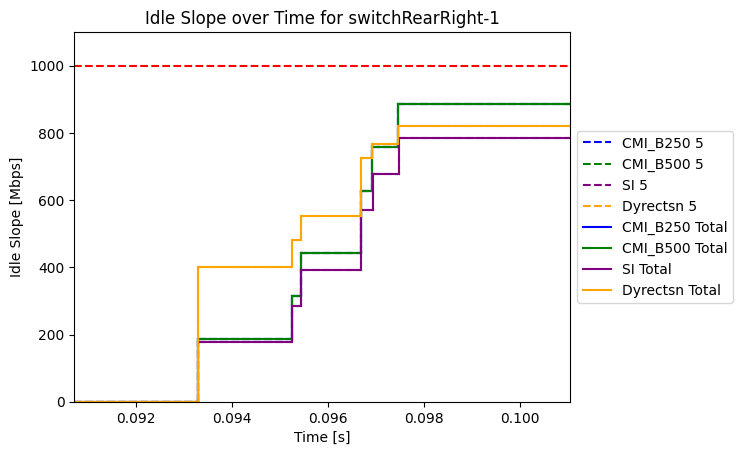

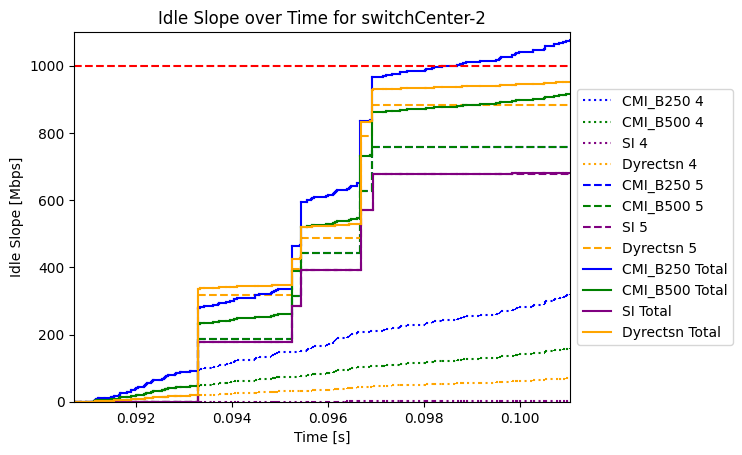

In [215]:
scenarioColors = {
    "CMI_B250": "blue",
    "CMI_B500": "green",
    "CMI_B1000": "yellow",
    "SI": "purple",
    "Dyrectsn": "orange",
    "SI_NoSDScatter": "black"
}

pcpLine = {
    4: "dotted",
    5: "dashed",
    "Total": "solid"
}

tMin, tMax = getTMinAndTMaxForAll(soiIdleSlopeVecs)
switch = "switchCenter-2"
firstScenario = list(soiIdleSlopeVecs.keys())[0]
# plot the soiIdleSlopeVecs for each switch, separate the two switch ports into two subplots
for switch in soiIdleSlopeVecs[firstScenario]:
    fig, ax = plt.subplots()
    for pcp in soiIdleSlopeVecs[scenario][switch]:
        for scenario in soiIdleSlopeVecs:
            if "Scatter" in scenario or "1000" in scenario:
                continue
            x = soiIdleSlopeVecs[scenario][switch][pcp]["time"]
            if len(x) <= 2:
                continue
            y = [val / 1000000 for val in soiIdleSlopeVecs[scenario][switch][pcp]["value"]]
            # plot as a stair case plot
            for i in range(len(x)-1):
                ax.plot([x[i], x[i+1]], [y[i], y[i]], color=scenarioColors[scenario], linestyle=pcpLine[pcp])
                ax.plot([x[i+1], x[i+1]], [y[i], y[i+1]], color=scenarioColors[scenario], linestyle=pcpLine[pcp])
            # add a label to the legend
            ax.plot([0, 0], [0, 0], color=scenarioColors[scenario], label=scenario + " " + str(pcp), linestyle=pcpLine[pcp])
    # plot a red line at 1 gbit/s
    ax.axhline(y=1000, color='r', linestyle='--')  
    ax.set_xlim(tMin, tMax)      
    ax.set_ylim(0, 1100)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Idle Slope [Mbps]")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Idle Slope over Time for " + switch)
    plt.show()

In [221]:
def getMaxLengthOfIdleSlopeVector(idleSlopeVector):
    maxLength = 0
    for pcp in idleSlopeVector:
        if idleSlopeVector[pcp] != None:
            if len(idleSlopeVector[pcp]["time"]) > maxLength:
                maxLength = len(idleSlopeVector[pcp]["time"])
    return maxLength

def getMaxLengthOfAllIdleSlopeVectors(soiIdleSlopeVecs):
    maxLength = 0
    for scenario in soiIdleSlopeVecs:
        for switch in soiIdleSlopeVecs[scenario]:
            length = getMaxLengthOfIdleSlopeVector(soiIdleSlopeVecs[scenario][switch])
            if length > maxLength:
                maxLength = length
    return maxLength

switch = "switchCenter-2"
outfile = switch + "_idleslopes.csv"
with open(outfile, 'w') as csv:
    # compile header:
    line = ""
    first = True
    for scenario in soiIdleSlopeVecs:
        if "Scatter" in scenario or "1000" in scenario:
            continue
        for pcp in soiIdleSlopeVecs[scenario][switch]:
            if first:
                first = False
            else:
                line += ", "
            line += scenario + "_" + str(pcp) + "_time, " + scenario + "_" + str(pcp) + "_value"
            print("\\addplot [thick, no markers] table [x=" + scenario + "_" + str(pcp) + "_time, y=" + scenario + "_" + str(pcp) + "_value, col sep=comma] {data/car/"+ outfile + "};")
    csv.write(line + "\n")
    # compile data:
    maxLength = getMaxLengthOfAllIdleSlopeVectors(soiIdleSlopeVecs)
    for i in range(maxLength):
        line = ""
        first = True
        for scenario in soiIdleSlopeVecs:
            if "Scatter" in scenario or "1000" in scenario:
                continue
            for pcp in soiIdleSlopeVecs[scenario][switch]:
                if first:
                    first = False
                else:
                    line += ", "
                if i < len(soiIdleSlopeVecs[scenario][switch][pcp]["time"]):
                    line += str(soiIdleSlopeVecs[scenario][switch][pcp]["time"][i]) + ", " + str(soiIdleSlopeVecs[scenario][switch][pcp]["value"][i])
                else:
                    line += ", "
        csv.write(line + "\n")
    

\addplot [thick, no markers] table [x=CMI_B250_4_time, y=CMI_B250_4_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B250_5_time, y=CMI_B250_5_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B250_Total_time, y=CMI_B250_Total_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B500_4_time, y=CMI_B500_4_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B500_5_time, y=CMI_B500_5_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=CMI_B500_Total_time, y=CMI_B500_Total_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=SI_4_time, y=SI_4_value, col sep=comma] {data/car/switchCenter-2_idleslopes.csv};
\addplot [thick, no markers] table [x=SI_5_time, y=SI_5_value, col sep=c

### Setup Time
**.services[*].startTime = 0.09s + initial delay of 0 - 10 ms

finished = max(endpointCreatedAt, connectedRemotes)

setup time = finished - startTime

In [217]:
subCreatedFiles = []
pubCreatedFiles = []
subConnectedRemotesFiles = []
pubConnectedRemotesFiles = []
for scenario in scenarios:
    subCreatedFiles.append(simFolder + "/" + scenario + sufSubCreated)
    pubCreatedFiles.append(simFolder + "/" + scenario + sufPubCreated)
    subConnectedRemotesFiles.append(simFolder + "/" + scenario + sufSubRemotes)
    pubConnectedRemotesFiles.append(simFolder + "/" + scenario + sufPubRemotes)
subCreatedFiles = validFiles(subCreatedFiles)
pubCreatedFiles = validFiles(pubCreatedFiles)
subConnectedRemotesFiles = validFiles(subConnectedRemotesFiles)
pubConnectedRemotesFiles = validFiles(pubConnectedRemotesFiles)
print(subCreatedFiles)
print(pubCreatedFiles)
print(subConnectedRemotesFiles)
print(pubConnectedRemotesFiles)

['./CMI_B250_SubCreated.json', './CMI_B500_SubCreated.json', './CMI_B1000_SubCreated.json', './SI_SubCreated.json', './Dyrectsn_SubCreated.json', './SI_NoSDScatter_SubCreated.json']
['./CMI_B250_PubCreated.json', './CMI_B500_PubCreated.json', './CMI_B1000_PubCreated.json', './SI_PubCreated.json', './Dyrectsn_PubCreated.json', './SI_NoSDScatter_PubCreated.json']
['./CMI_B250_SubRemotes.json', './CMI_B500_SubRemotes.json', './CMI_B1000_SubRemotes.json', './SI_SubRemotes.json', './Dyrectsn_SubRemotes.json', './SI_NoSDScatter_SubRemotes.json']
['./CMI_B250_PubRemotes.json', './CMI_B500_PubRemotes.json', './CMI_B1000_PubRemotes.json', './SI_PubRemotes.json', './Dyrectsn_PubRemotes.json', './SI_NoSDScatter_PubRemotes.json']


In [218]:
def getLastSubCreated(simFile):
    sim = pd.read_json(simFile)
    lastSubCreated = 0
    study = list(sim.keys())[0]
    for scalar in sim[study]["scalars"]:
        if "middleware.subscriberEndpoints" not in scalar["module"]:
            continue
        if "endpointCreated" in scalar["name"]:
            if scalar["value"] > lastSubCreated:
                lastSubCreated = scalar["value"]
    return lastSubCreated

def getLastPubCreated(simFile):
    sim = pd.read_json(simFile)
    lastPubCreated = 0
    study = list(sim.keys())[0]
    for scalar in sim[study]["scalars"]:
        if "middleware.publisherEndpoints" not in scalar["module"]:
            continue
        if "endpointCreated" in scalar["name"]:
            if scalar["value"] > lastPubCreated:
                lastPubCreated = scalar["value"]
    return lastPubCreated

def getLastPubConnectedRemotes(simFile):
    sim = pd.read_json(simFile)
    lastPubRemotes = 0
    study = list(sim.keys())[0]
    for vector in sim[study]["vectors"]:
        if "middleware.publisherEndpoints" not in vector["module"]:
            continue
        if "connectedRemotes" in vector["name"]:
            lastPubRemotes = np.max([np.max(vector["time"]),lastPubRemotes])
    return lastPubRemotes

In [219]:
lastSubsCreated = dict()
for file in subCreatedFiles:
    scenario = getScenarioFromFileName(file)
    lastSubsCreated[scenario] = getLastSubCreated(file)
print(lastSubsCreated)
lastPubsCreated = dict()
for file in pubCreatedFiles:
    scenario = getScenarioFromFileName(file)
    lastPubsCreated[scenario] = getLastPubCreated(file)
print(lastPubsCreated)
lastPubConnectedRemotes = dict()
for file in pubConnectedRemotesFiles:
    scenario = getScenarioFromFileName(file)
    lastPubConnectedRemotes[scenario] = getLastPubConnectedRemotes(file)
print(lastPubConnectedRemotes)

{'CMI_B250': 0.101061524582, 'CMI_B500': 0.101061524582, 'CMI_B1000': 0.101061524582, 'SI': 0.101059434371, 'Dyrectsn': 0.101058504101, 'SI_NoSDScatter': 0.092167157}
{'CMI_B250': 0.100834772184, 'CMI_B500': 0.100834772184, 'CMI_B1000': 0.100834772184, 'SI': 0.100838907527, 'Dyrectsn': 0.100837201824, 'SI_NoSDScatter': 0.09100058200000001}
{'CMI_B250': 0.100845857306, 'CMI_B500': 0.100845857306, 'CMI_B1000': 0.100845857306, 'SI': 0.100843087527, 'Dyrectsn': 0.10084331110099999, 'SI_NoSDScatter': 0.091901958}


In [220]:
start = 0.09
setupTimes = dict()
for scenario in lastSubsCreated:
    lastCreated = np.max([lastSubsCreated[scenario], lastPubsCreated[scenario], lastPubConnectedRemotes[scenario]])
    setupTimes[scenario] = lastCreated - start
    print(scenario, format(setupTimes[scenario]*1000, ".1f"), "ms")

CMI_B250 11.1 ms
CMI_B500 11.1 ms
CMI_B1000 11.1 ms
SI 11.1 ms
Dyrectsn 11.1 ms
SI_NoSDScatter 2.2 ms


## Latency

In [222]:
latencyFiles = []
for scenario in scenarios:
    latencyFiles.append(simFolder + "/" + scenario + sufE2E)
latencyFiles = validFiles(latencyFiles)
print(latencyFiles)

['./CMI_B250_E2EDelay.json', './CMI_B500_E2EDelay.json', './CMI_B1000_E2EDelay.json', './SI_E2EDelay.json', './Dyrectsn_E2EDelay.json', './SI_NoSDScatter_E2EDelay.json']


In [228]:
def getServiceNum (module):
    return int(module.split(".")[-1].split("[")[1].split("]")[0])

def getServiceName (attributes):
    return attributes["moduledisplaypath"].split(".")[-1]

def getEndToEndLatencies(simFile):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        for vector in sim[study]["vectors"]:
            if "rxLatency" in vector["name"]:
                module = vector["module"]
                node = getNodeFromModule(module)
                service = getServiceNum(module)
                serviceName = getServiceName(vector["attributes"])
                if node not in results:
                    results[node] = dict()
                if service not in results[node]:
                    results[node][service] = dict()
                results[node][service]["name"] = serviceName
                results[node][service]["time"] = vector["time"]
                results[node][service]["value"] = vector["value"]
    return results

def getMinAvgMaxE2ELatency(e2eLatencies):
    min = 1000000000
    max = 0
    sum = 0
    count = 0
    for node in e2eLatencies:
        for service in e2eLatencies[node]:
            if len(e2eLatencies[node][service]["value"]) == 0:
                print("No values for ", node, service, e2eLatencies[node][service]["name"])
                continue
            curMin = np.min(e2eLatencies[node][service]["value"])
            curMax = np.max(e2eLatencies[node][service]["value"])
            curMean = np.mean(e2eLatencies[node][service]["value"])
            if curMin < min:
                min = curMin
            if curMax > max:
                max = curMax
            sum += curMean
            count += 1
    return min, sum/count, max
              


In [230]:
e2eLatencies = dict()
for file in latencyFiles:
    scenario = getScenarioFromFileName(file)
    print(scenario)
    e2eLatencies[scenario] = getEndToEndLatencies(file)
    min, avg, max = getMinAvgMaxE2ELatency(e2eLatencies[scenario])
    print(scenario, min, avg, max)

CMI_B250
No values for  zonalControllerRearRight 88 SControl_123 sink
No values for  zonalControllerRearRight 111 SControl_90 sink
No values for  zonalControllerRearRight 153 SControl_148 sink
No values for  zonalControllerRearRight 90 SControl_81 sink
No values for  zonalControllerRearRight 104 SControl_164 sink
No values for  zonalControllerRearRight 113 SControl_93 sink
No values for  zonalControllerRearRight 156 SControl_167 sink
No values for  zonalControllerRearRight 157 SControl_92 sink
No values for  zonalControllerRearRight 158 SControl_107 sink
No values for  zonalControllerRearRight 160 SControl_105 sink
No values for  zonalControllerRearRight 161 SControl_186 sink
No values for  zonalControllerRearRight 163 SControl_174 sink
No values for  zonalControllerRearRight 165 SControl_149 sink
No values for  zonalControllerRearRight 162 SControl_163 sink
No values for  zonalControllerRearRight 154 SControl_142 sink
No values for  zonalControllerRearRight 159 SControl_200 sink
No va